# Training with XGB algorithm
This was conducted on Google Colab.

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
def check_classification(model, X_train, X_test, y_train, y_test, y_labels):

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    print('--- Test data ---')
    print(classification_report(y_test, y_pred, target_names=y_labels))
    print('--- Train data ---')
    print(classification_report(y_train, y_pred_train, target_names=y_labels))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].set_title('Test Data')
    cmd_test = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=y_labels, values_format="d", cmap=plt.cm.Blues, ax=axes[0])
    plt.xticks(rotation=30, ha='right')

    axes[1].set_title('Train Data')
    cmd_test = ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, display_labels=y_labels, values_format="d", cmap=plt.cm.Greens, ax=axes[1])

    plt.xticks(rotation=30, ha='right')

In [3]:
# Read parquet files for training and test data
train_data = pd.read_parquet('/content/drive/MyDrive/Data/scvi_normalized_train.parquet')
test_data = pd.read_parquet('/content/drive/MyDrive/Data/scvi_normalized_test.parquet')

In [4]:
train_data.shape

(71958, 1177)

In [5]:
test_data.shape

(21593, 1177)

In [6]:
## Assign the target and feature variables
X_train = train_data.copy().drop(columns=["target"], axis=1)
y_train = train_data["target"]
X_test = test_data.copy().drop(columns=["target"], axis=1)
y_test = test_data["target"]

In [7]:
y_train.value_counts()

,count
target,
Normal,29530
EMS,28626
Cancer,13802


In [8]:
y_test.value_counts()

,count
target,
Normal,12314
Cancer,5051
EMS,4228


Consider imbalance!

In [9]:
# Encode the target varaible
y_train = y_train.map({"Normal": 0, "EMS": 1, "Cancer": 2})
y_test = y_test.map({"Normal": 0, "EMS": 1, "Cancer": 2})
y_labels=["Normal", "EMS", "Cancer"]

# Modelling

In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline

# 1. Split data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# 2. Create preprocessing pipeline (without classifier)
preprocessor = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(sampling_strategy='not majority', random_state=42))
])

# 3. Fit and resample training data
X_tr_res, y_tr_res = preprocessor.fit_resample(X_tr, y_tr)

# 4. Transform validation data (only scale, no SMOTE)
# Important: SMOTE should NOT be applied to validation/test data
X_val_scaled = preprocessor.named_steps['scaler'].transform(X_val)

# 5. Train XGB with early stopping
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=1000,
    max_depth=6,
    reg_alpha=0.5,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    device='cuda',
    random_state=42,
    early_stopping_rounds=50
)
xgb.fit(
    X_tr_res, y_tr_res,
    eval_set=[(X_val_scaled, y_val)],
    verbose=True
)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:01:21] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:01:21] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.92766
[1]	validation_0-mlogloss:0.75351
[2]	validation_0-mlogloss:0.68292
[3]	validation_0-mlogloss:0.59333
[4]	validation_0-mlogloss:0.53344
[5]	validation_0-mlogloss:0.47025
[6]	validation_0-mlogloss:0.41545
[7]	validation_0-mlogloss:0.35584
[8]	validation_0-mlogloss:0.31704
[9]	validation_0-mlogloss:0.28244
[10]	validation_0-mlogloss:0.25211
[11]	validation_0-mlogloss:0.23012
[12]	validation_0-mlogloss:0.19941
[13]	validation_0-mlogloss:0.18325
[14]	validation_0-mlogloss:0.16690
[15]	validation_0-mlogloss:0.15074
[16]	validation_0-mlogloss:0.13360
[17]	validation_0-mlogloss:0.12222
[18]	validation_0-mlogloss:0.11289
[19]	validation_0-mlogloss:0.10352
[20]	validation_0-mlogloss:0.09772
[21]	validation_0-mlogloss:0.09485
[22]	validation_0-mlogloss:0.08899
[23]	validation_0-mlogloss:0.08276
[24]	validation_0-mlogloss:0.07636
[25]	validation_0-mlogloss:0.07017
[26]	validation_0-mlogloss:0.06581
[27]	validation_0-mlogloss:0.06194
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=50,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_class=3, num_parallel_tree=None, ...)

In [11]:
# Apply log transform to test data
X_test_log = preprocessor.named_steps['log'].transform(X_test)

# Apply MinMaxScaler (use the one fitted on training data)
X_test_scaled = preprocessor.named_steps['scaler'].transform(X_test_log)

--- Test data ---
              precision    recall  f1-score   support

      Normal       0.86      0.76      0.81     12314
         EMS       0.48      0.63      0.54      4228
      Cancer       0.99      1.00      1.00      5051

    accuracy                           0.79     21593
   macro avg       0.78      0.80      0.78     21593
weighted avg       0.82      0.79      0.80     21593

--- Train data ---
              precision    recall  f1-score   support

      Normal       1.00      0.74      0.85     23624
         EMS       0.78      1.00      0.87     22901
      Cancer       0.99      0.95      0.97     11041

    accuracy                           0.88     57566
   macro avg       0.92      0.90      0.90     57566
weighted avg       0.91      0.88      0.88     57566



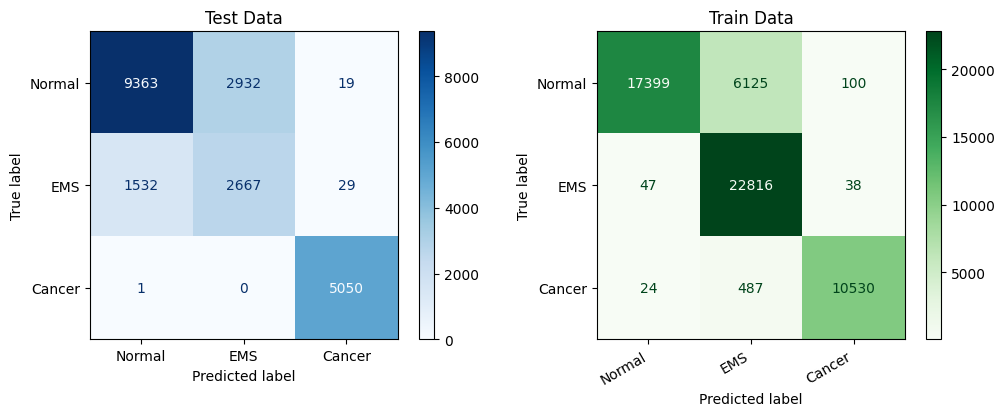

In [12]:
check_classification(xgb, X_tr, X_test_scaled, y_tr, y_test, y_labels)

In [23]:
# Saving the model
import pickle
# Save the model to a file
with open('ML_model_XGC.pkl', 'wb') as f:
    pickle.dump(xgb, f)

# Feature Importance Extraction

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assume clf is your trained classifier, X_test and y_test are your test data
importances = permutation_importance(
    xgb, X_test, y_test,
    n_repeats=3,
    random_state=42,
    scoring='f1_weighted'
)

In [17]:
importances

{'importances_mean': array([ 0.        , -0.00100184,  0.00010109, ..., -0.00113238,
         0.        ,  0.        ]),
 'importances_std': array([0.00000000e+00, 8.35075037e-05, 3.77436769e-05, ...,
        3.86998795e-04, 0.00000000e+00, 0.00000000e+00]),
 'importances': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.01335229e-03, -1.09786516e-03, -8.94289331e-04],
        [ 5.06509907e-05,  1.41438537e-04,  1.11172529e-04],
        ...,
        [-5.95675060e-04, -1.30791552e-03, -1.49354380e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])}

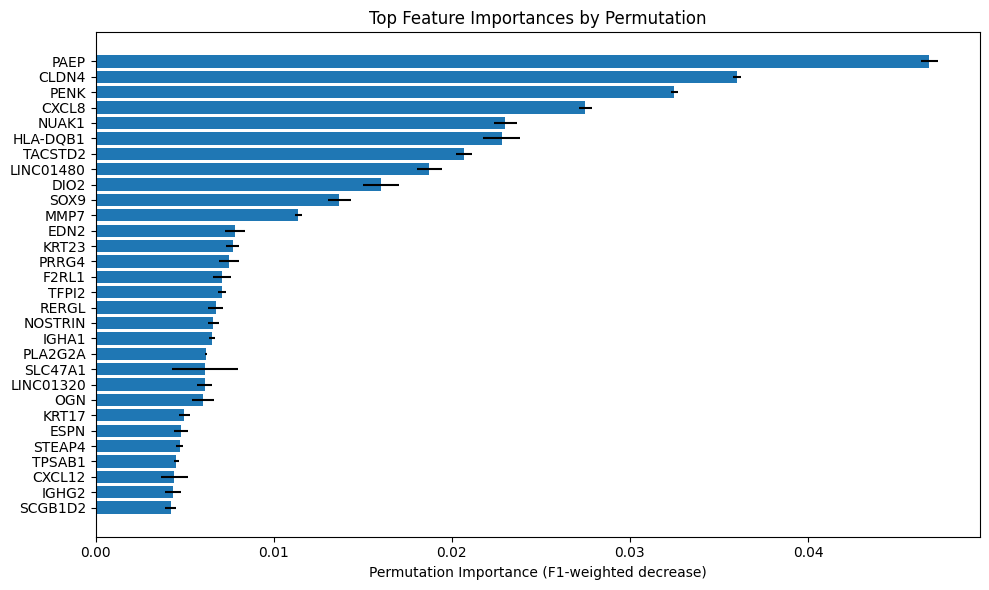

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get importances and sort by descending importance
sorted_idx = importances.importances_mean.argsort()[::-1]

# Number of top features to plot (optional)
top_n = 30
top_idx = sorted_idx[:top_n]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances.importances_mean[top_idx][::-1],
         xerr=importances.importances_std[top_idx][::-1], align='center')
plt.yticks(range(top_n), np.array(X_test.columns)[top_idx][::-1])  # Assumes X_test is a DataFrame
plt.xlabel("Permutation Importance (F1-weighted decrease)")
plt.title("Top Feature Importances by Permutation")
plt.tight_layout()
plt.show()

Reduce features to those secreted and detected in blood according to the Human Protein Atlas. Here the features in correct order: <br>
* PAEP
* PENK
* CXCL8
* TACSTD2
* MMP7
* KRT23
* TFP12
* IGHA1
* PLA2G2
* OGN
* KRT17
* TPSAB1
* CXCL12
* IGHG2